In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# covid <a name="top-of-covid-notebook"></a>
> Visualise the John Hopkins Covid-19 dataset with a little help from [nbdev](http://nbdev.fast.ai/).

In [ ]:
#hide
from covid.core import *

## Contents
1. [Introduction](#covid-intro)
2. [Installation](#covid-install)
3. [Graphing current counts](#covid-current)
4. [Graphing time series counts](#covid-timeseries)
5. [Graphing new vs. existing cases](#covid-newexisting)
5. [Graphing current and time series counts using Covid API](#covid-api)

## 1. Introduction <a name="covid-intro"></a>
#### [back](#top-of-covid-notebook)

The accompanying `covid` module built using [nbdev](http://nbdev.fast.ai/) provides convenience utilities for graphing the covid-19 dataset published by John Hopkins University (JHU) [here](https://github.com/CSSEGISandData/COVID-19).  The JHU dataset is updated daily with the latest in separate time series csv files covering [here](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series):
* `time_series_covid19_confirmed_global.csv`
* `time_series_covid19_deaths_global.csv`
* `time_series_covid19_recovered_global.csv`

Daily reports are kept in [this directory](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports) and conform to the format `dd-mm-2020.csv`.

## 2. Installation <a name="covid-install"></a>
#### [back](#top-of-covid-notebook)

This code is not yet in PyPI.  You can clone the repo and the corresponding functions described below will all be available in the accompanying `covid` module.  The `covid` module has the following dependencies which will need to be pip installed: `requests`,`pandas`,`matplotlib`,`seaborn`

## 3. Graphing current counts <a name="covid-current"></a>
#### [back](#top-of-covid-notebook)

You can use `getCountriesDailyReport` to obtain a `pandas` dataframe `df` holding the latest values for each of `["Confirmed","Deaths","Recovered"]` by both `Province_State` and `Country_Region` as follows:

In [ ]:
which = getDayBeforeYesterday()
df = getCountriesDailyReport(which)

You can view the structure of `df` as follows:

In [ ]:
n = 1
nrows,ncols = df.shape
print(f'df has {nrows} rows and {ncols} columns with column names {df.columns.to_list()}')
print(f'First {n} rows are:')
print(df.iloc[:n,:])

df has 2679 rows and 12 columns with column names ['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key']
First 1 rows are:
      FIPS     Admin2  Province_State Country_Region         Last_Update  \
0  45001.0  Abbeville  South Carolina             US 2020-04-04 23:34:21   

         Lat      Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334 -82.461707          6       0          0       0   

                    Combined_Key  
0  Abbeville, South Carolina, US  


You can plot this data aggregated by country and `kind` as follows.  Note here that `setDefaults` configures the graphs to be drawn using the [seaborn](https://seaborn.pydata.org/introduction.html) visualisation library when the visualisation parameter is set to `matplotlib`.  We can also use or the `altair` visualisation library as an alternative `viz`:

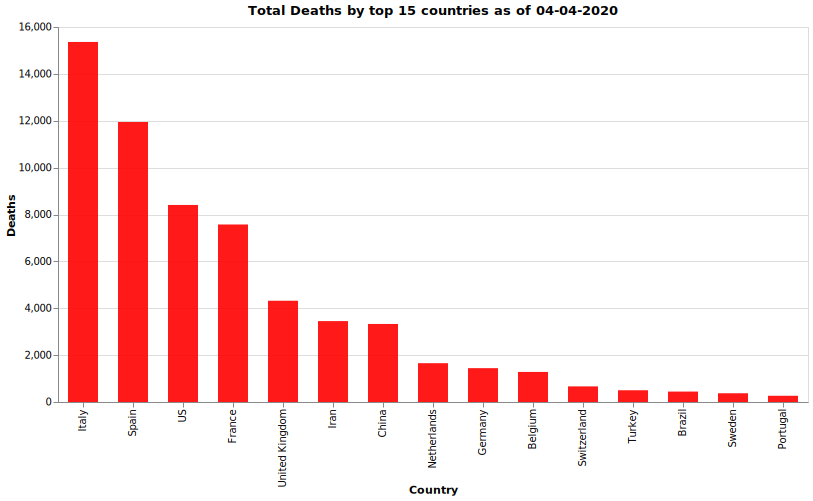

In [ ]:
setDefaults()
viz = 'altair'
plotCountriesDailyReport(getCountriesDailyReport(which), which, topN=15, color='red', kind='Deaths',visualisation=viz)

We can also dig into the breakdown per country if available as follows:

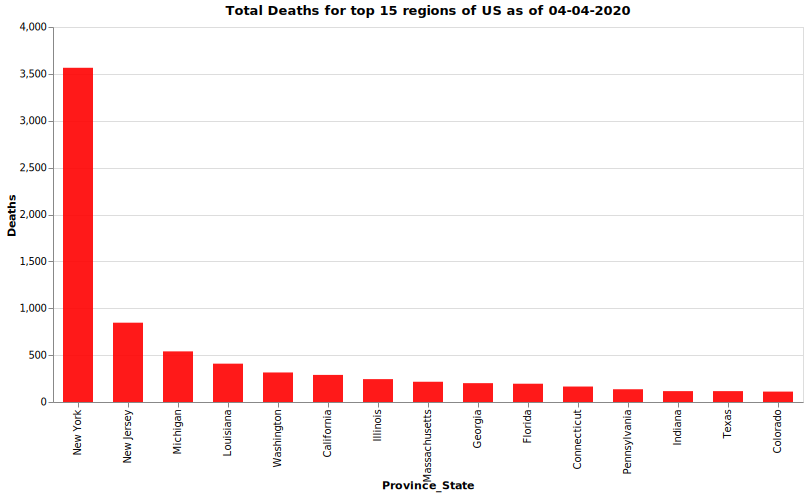

In [ ]:
plotCountryDailyReport(getCountriesDailyReport(which), 'US', which, topN=15, color='red', kind='Deaths', visualisation=viz)

## 4. Graphing time series counts <a name="covid-timeseries"></a>
#### [back](#top-of-covid-notebook)

We can look at how infection and death counts have varied for a county over time if we aggregate by doing a `groupby` on `country`.  We should see an equal number of values per country following this aggregation:  

In [ ]:
df = procTimeSeriesConfirmed()
print(f'Found {df.shape} (rows, cols) of cols={df.columns.values}')
ddf = df.groupby('country')['Confirmed'].count().sort_values(ascending=True)
print(f'max={ddf.max()}, min={ddf.min()}, count={len(ddf)}')

Found (13725, 4) (rows, cols) of cols=['day' 'country' 'Confirmed' 'LogConfirmed']
max=75, min=75, count=183


Now we can plot a time series of confirmed cases of Covid-19 in China, Italy, US and UK as follows:

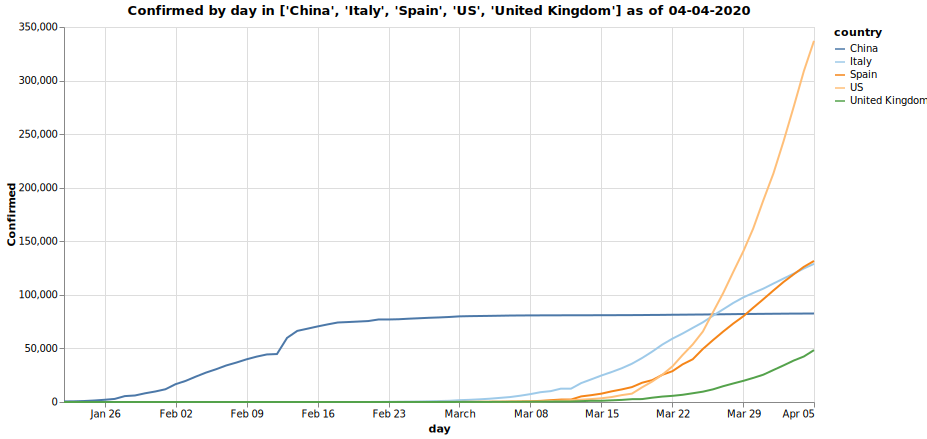

In [ ]:
plotCountriesTimeSeries(df, ['China', 'Italy', 'Spain', 'US', 'United Kingdom'], which, x='day', y='Confirmed', visualisation=viz)

And we can plot a time series of recorded deaths in these same countries as follows:

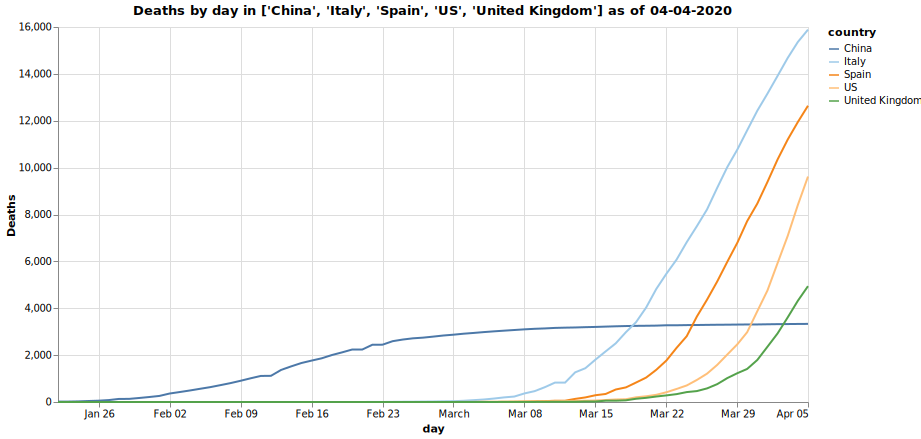

In [ ]:
df = procTimeSeriesDeaths()
plotCountriesTimeSeries(df, ['China', 'Italy', 'Spain', 'US', 'United Kingdom'], which, x='day', y='Deaths', visualisation=viz)

We can also view these as a log series over time:

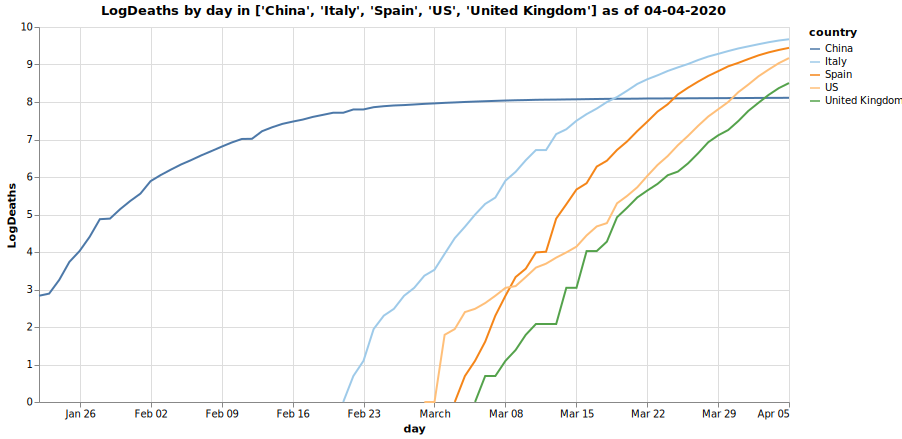

In [ ]:
plotCountriesTimeSeries(df, ['China', 'Italy', 'Spain', 'US', 'United Kingdom'], which, x='day', y='LogDeaths', visualisation=viz)

## 5. Graphing new versus existing cases<a name="covid-newexisting"></a>
#### [back](#top-of-covid-notebook)

[This video](https://youtu.be/54XLXg4fYsc) provides an excellent demystifier on how to view the Covid data using the following ground rules:
* Use a log scale
* Focus on change not absolute numbers
* Don't plot against time

From this analysis we see that we want to diff `Confirmed` cases between days to build up an `New` column and then plot the logs of both against each other as follows:

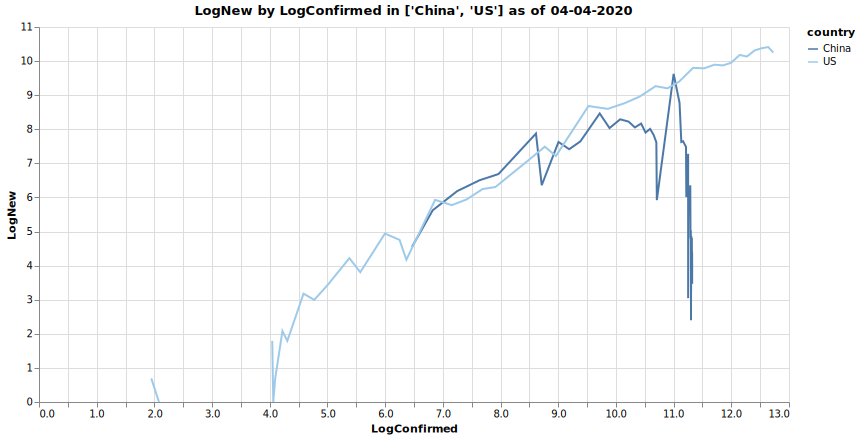

In [ ]:
ndf = procNewCasesTimeSeries(procTimeSeriesConfirmed(), 'Confirmed')
plotCountriesTimeSeries(ndf, ['China', 'US'], which, x='LogConfirmed', y='LogNew', visualisation=viz)

We can look at the same ddata across a wider range of countries as follows:

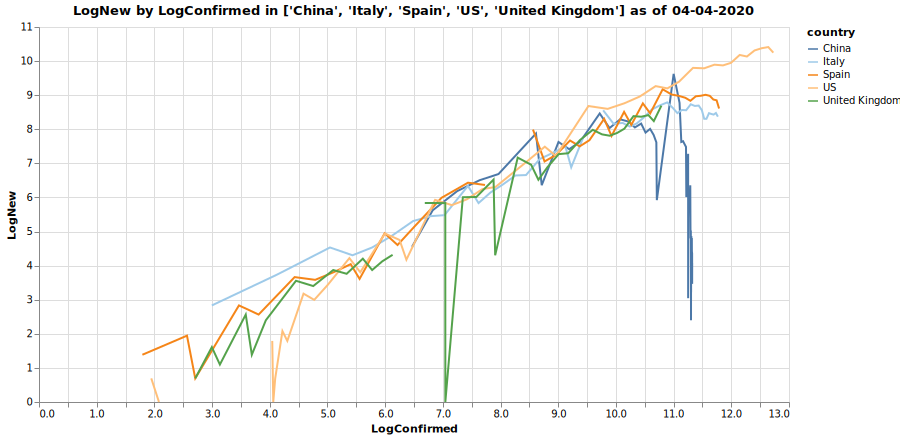

In [ ]:
countries = ['China', 'Italy', 'Spain', 'US', 'United Kingdom']
plotCountriesTimeSeries(ndf, countries, which, x='LogConfirmed', y='LogNew', visualisation=viz)

We can also view the same set of countries in a similar way in respect of deaths.  Note here the grid is being removed for clarity:

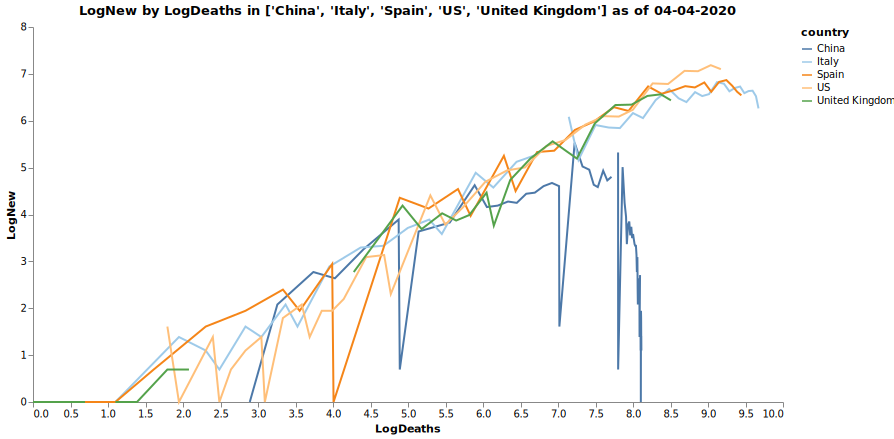

In [ ]:
ndf = procNewCasesTimeSeries(procTimeSeriesDeaths(), 'Deaths')
plotCountriesTimeSeries(ndf, countries, which, x='LogDeaths', y='LogNew', grid=False, visualisation=viz)

It would be nice to view that data  also want to fix up the display of the log axis markers so they show the actual numbers and to filter out some of the low data values to make the trends a bit clearer.  We can do that by setting `log` true as follows and leaving the grid on (note this only works for `altair` right now):

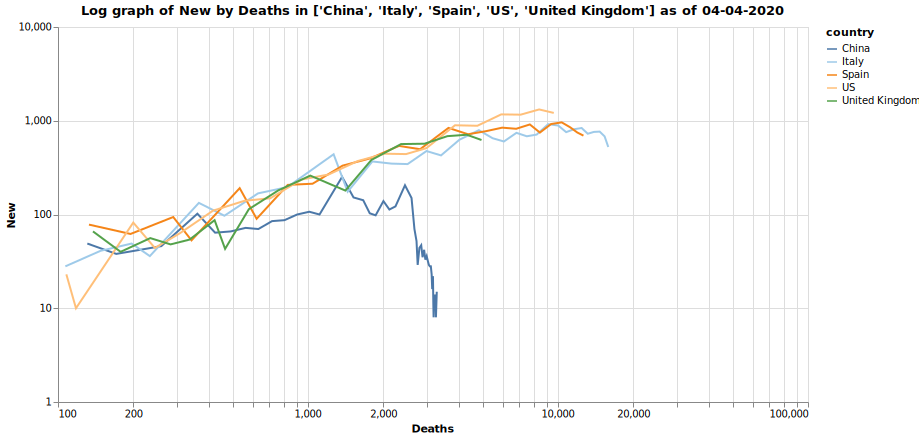

In [ ]:
ndf = procNewCasesTimeSeries(procTimeSeriesDeaths(), 'Deaths')
plotCountriesTimeSeries(ndf, countries, which, x='Deaths', y='New', log=True, grid=True, visualisation=viz)

## 6. Graphing current and time series counts using Covid API <a name="covid-api"></a>
#### [back](#top-of-covid-notebook)

[This site](https://covid19api.com/) details an API that nicely wraps up the same JHU dataset and presents it as `json` via a REST API which allows us to go from API call to formatted graph showing cases and deaths by country using `altair` as follows:

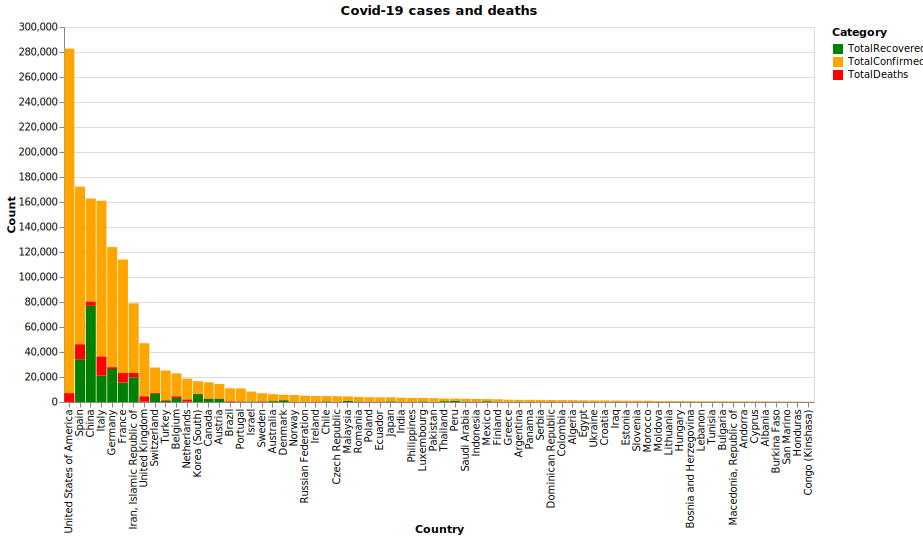

In [ ]:
plotCountriesDailyReportFromAPI(visualisation=viz)

There used to be an issue with normalisation of this data a while back with Iran and South Korea appearing twice but that seems to have been fixed.

It's also possible to do timeseries representation using this API by country using `altair` as follows for the US confirmed cases:

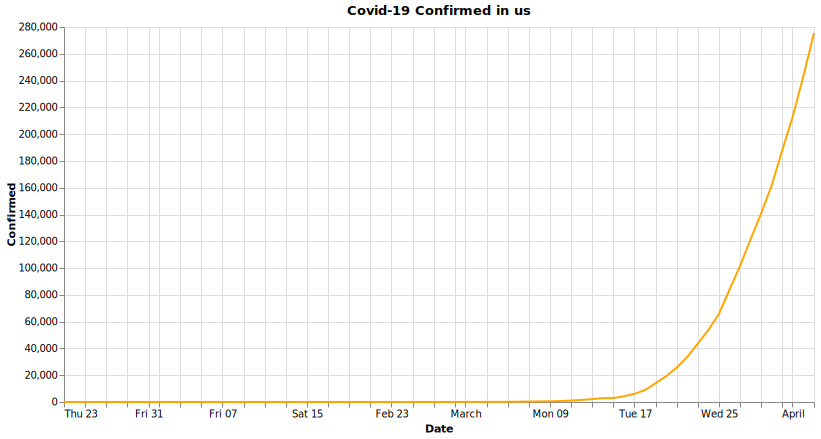

In [ ]:
plotCategoryByCountryFromAPI('Confirmed', 'us', color='orange', visualisation=viz)

We can also look at the same data in log format:

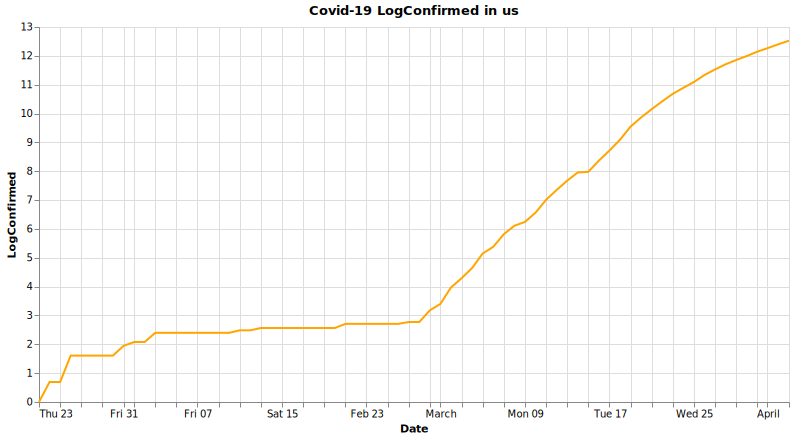

In [ ]:
plotCategoryByCountryFromAPI('Confirmed', 'us', color='orange', log=True, visualisation=viz)

We can also look at Deaths in this case in log format:

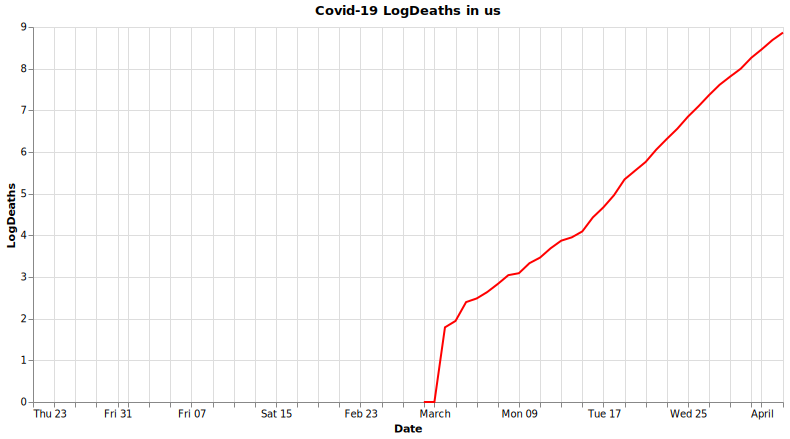

In [ ]:
plotCategoryByCountryFromAPI('Deaths', 'us', color='red', log=True, visualisation=viz)